In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset , Dataset
from sklearn.model_selection import train_test_split

In [55]:
# set random seed for reproducibility
torch.manual_seed(42)

In [56]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [57]:
# Load the Fashion-MNIST dataset
df = pd.read_csv(r'D:\Deep Learning\Convolutional-Neural-Network(CNN)\MNIST_Fashion-data\fmnist_small.csv')
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,0,0,0,0,0,0,0,0,0,...,69,12,0,0,0,0,0,0,0,0
5996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5997,8,0,0,0,0,0,0,0,0,0,...,39,47,2,0,0,29,0,0,0,0
5998,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
df.shape

(6000, 785)

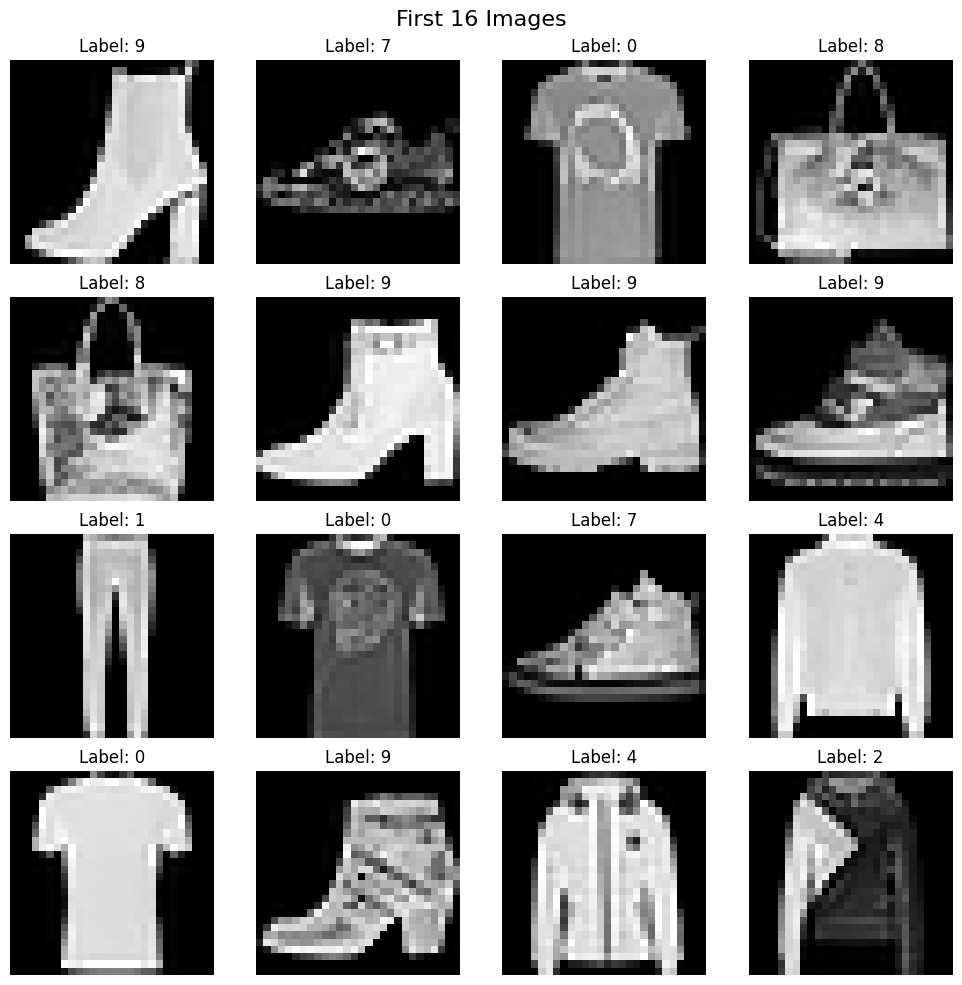

In [59]:
# create a 4x4 grid of images
fig,axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('First 16 Images', fontsize=16)

#plot the first 16 images from the dataset
for i , ax in enumerate(axes.flat):
    image = df.iloc[i, 1:].values.reshape(28, 28) # reshape the pixel values to 28x28
    ax.imshow(image, cmap='gray') # display the image in grayscale
    ax.set_title(f'Label: {df.iloc[i, 0]}') # set the title to the label of the image
    ax.axis('off') # turn off the axis

    plt.tight_layout() # adjust the layout to prevent overlap

In [60]:
# train test split
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [ ]:
train_dataset = CustomDataset(X_train , y_train)

In [ ]:
test_dataset = CustomDataset(X_test , y_test)

In [66]:
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True , pin_memory=True)
test_loader = DataLoader(test_dataset , batch_size=32 , shuffle=False , pin_memory=True)

In [71]:
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [72]:
learning_rate = 0.01
epochs = 100

In [74]:
model = MyNN(1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

In [75]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


c:\Users\hb292\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch: 1 , Loss: 1.4394914269447328
Epoch: 2 , Loss: 0.97115298807621
Epoch: 3 , Loss: 0.8463879623015722
Epoch: 4 , Loss: 0.7295789049069087
Epoch: 5 , Loss: 0.6997339514891306
Epoch: 6 , Loss: 0.6713680549462636
Epoch: 7 , Loss: 0.6372313633561134
Epoch: 8 , Loss: 0.6003765934705734
Epoch: 9 , Loss: 0.642744133969148
Epoch: 10 , Loss: 0.5885377289851507
Epoch: 11 , Loss: 0.5826547684272131
Epoch: 12 , Loss: 0.5646291961272557
Epoch: 13 , Loss: 0.5584958939750989
Epoch: 14 , Loss: 0.5709505219260852
Epoch: 15 , Loss: 0.5471750621994337
Epoch: 16 , Loss: 0.6230831774075826
Epoch: 17 , Loss: 0.5795945719877879
Epoch: 18 , Loss: 0.5404884699980418
Epoch: 19 , Loss: 0.5114526727795601
Epoch: 20 , Loss: 0.5345594542225202
Epoch: 21 , Loss: 0.4821060965458552
Epoch: 22 , Loss: 0.48762409468491874
Epoch: 23 , Loss: 0.550321962783734
Epoch: 24 , Loss: 0.7175162752469381
Epoch: 25 , Loss: 0.607950418094794
Epoch: 26 , Loss: 0.575860759516557
Epoch: 27 , Loss: 0.547697837650776
Epoch: 28 , Loss

In [76]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.7983333333333333


In [77]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8945833333333333
